In [1]:
import pandas as pd #importing the Pandas Library as 'pd'
import numpy as np

#Imports spatial libraries
from keplergl import KeplerGl #importing KeplerGl
import geopandas as gpd #importing geopandas as 'gpd'
from shapely.geometry import Point
from shapely.geometry import box
import shapely.wkt
from geopy.geocoders import Nominatim # Imports the geopy for the geocoding
import geojson
from geojson import Point, Feature, FeatureCollection, dump

import xml.etree.ElementTree as ET

import requests

from time import time

This map reads in data on (from the Data folder)
1. Lower super output areas and the index of multiple deprivation
2. Food outlets data
3. The location of foodbanks
4. Ward area data of Liverpool and associated data

and processes it 
- geocoding of point data - of food banks and food outlets 
- matches the ward area data to the ward shape files
- Converts the layer data (lsoas and wards) into qunitiles


and writes it out as four geojson files to the Out folder in the Data folder

# Reads in the Liverpool Lower Super Output Areas (lsoas) with index of multiple deprivation and creates quintile variables

In [2]:
filename = "Data/Liverpool_lsoa.geojson"
file = open(filename)
Liverpool_lsoa = gpd.read_file(file)

In [3]:
list(Liverpool_lsoa)

['LSOA11CD',
 'LSOA11NM',
 'LSOA code (2011)',
 'LSOA name (2011)_x',
 'Local Authority District code (2019)_x',
 'Local Authority District name (2019)_x',
 'Total population: mid 2015 (excluding prisoners)',
 'Dependent Children aged 0-15: mid 2015 (excluding prisoners)',
 'Population aged 16-59: mid 2015 (excluding prisoners)',
 'Older population aged 60 and over: mid 2015 (excluding prisoners)',
 'Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)',
 'LSOA name (2011)_y',
 'Local Authority District code (2019)_y',
 'Local Authority District name (2019)_y',
 'Income Domain numerator',
 'Income Deprivation Affecting Children Index (IDACI) numerator',
 'Income Deprivation Affecting Older People Index (IDAOPI) numerator',
 'Employment Domain numerator',
 'Staying on in education post 16 indicator',
 'Entry to higher education indicator',
 'Adult skills and English language proficiency indicator',
 'Years of potential life lost indicator',
 

In [4]:
metrics=['Total population: mid 2015 (excluding prisoners)',
 'Dependent Children aged 0-15: mid 2015 (excluding prisoners)',
 'Population aged 16-59: mid 2015 (excluding prisoners)',
 'Older population aged 60 and over: mid 2015 (excluding prisoners)',
 'Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)',
    'Income Domain numerator',
 'Income Deprivation Affecting Children Index (IDACI) numerator',
 'Income Deprivation Affecting Older People Index (IDAOPI) numerator',
 'Employment Domain numerator',
 'Staying on in education post 16 indicator',
 'Entry to higher education indicator',
 'Adult skills and English language proficiency indicator',
 'Years of potential life lost indicator',
 'Comparative illness and disability ratio indicator',
 'Acute morbidity indicator',
 'Mood and anxiety disorders indicator',
 'Road distance to a post office indicator (km)',
 'Road distance to a primary school indicator (km)',
 'Road distance to general store or supermarket indicator (km)',
 'Road distance to a GP surgery indicator (km)',
 'Household overcrowding indicator',
 'Homelessness indicator (rate per 1000 households)',
 'Owner-occupation affordability (component of housing affordability indicator)',
 'Private rental affordability (component of housing affordability indicator)',
 'Housing affordability indicator',
 'Housing in poor condition indicator',
 'Houses without central heating indicator',
 'Road traffic accidents indicator',
 'Nitrogen dioxide (component of air quality indicator)',
 'Benzene (component of air quality indicator)',
 'Sulphur dioxide (component of air quality indicator)',
 'Particulates (component of air quality indicator)',
 'Air quality indicator',
        ]

In [5]:
# Reads in the etl data 

efdi_engwales=pd.read_csv("Data/efdi_england.csv")

In [6]:
efdi_engwales.head(n=5)

,LSOA or DZ,Nation,Score,Rank,Decile
0,W01000532,Wales,70.82672,1.0,1.0
1,W01000545,Wales,70.54694,2.0,1.0
2,W01000471,Wales,70.51910,3.0,1.0
3,W01000529,Wales,70.37505,4.0,1.0
4,W01000506,Wales,70.23811,5.0,1.0


In [7]:
#Merge with the lsoa data
Liverpool_lsoa=Liverpool_lsoa.merge(efdi_engwales, how='inner', left_on='LSOA code (2011)', right_on='LSOA or DZ')

In [8]:
Liverpool_lsoa.head()

,LSOA11CD,LSOA11NM,LSOA code (2011),LSOA name (2011)_x,Local Authority District code (2019)_x,Local Authority District name (2019)_x,Total population: mid 2015 (excluding prisoners),Dependent Children aged 0-15: mid 2015 (excluding prisoners),Population aged 16-59: mid 2015 (excluding prisoners),Older population aged 60 and over: mid 2015 (excluding prisoners),...,Sulphur dioxide (component of air quality indicator),Particulates (component of air quality indicator),Air quality indicator,flag,geometry,LSOA or DZ,Nation,Score,Rank,Decile
0,Liverpool 050G,Liverpool 050G,E01032506,Liverpool 050G,Liverpool 050G,E08000012,326,208,0,0,...,0.49,0.0,1.04,1,"POLYGON ((-2.95426 53.38099, -2.95408 53.38093...",E01032506,England,18.12447,19503.0,6.0
1,Liverpool 050H,Liverpool 050H,E01032507,Liverpool 050H,Liverpool 050H,E08000012,233,183,0,0,...,0.49,0.0,1.04,1,"POLYGON ((-2.95186 53.38009, -2.95182 53.38007...",E01032507,England,10.59536,30235.0,9.0
2,Liverpool 050F,Liverpool 050F,E01032505,Liverpool 050F,Liverpool 050F,E08000012,295,233,0,0,...,0.49,0.0,1.04,1,"POLYGON ((-2.96348 53.37651, -2.96314 53.37672...",E01032505,England,25.28833,10160.0,3.0
3,Liverpool 027G,Liverpool 027G,E01032508,Liverpool 027G,Liverpool 027G,E08000012,335,344,0,0,...,0.59,0.0,1.31,1,"POLYGON ((-2.91993 53.41418, -2.91991 53.41425...",E01032508,England,35.70778,3559.0,2.0
4,Liverpool 027H,Liverpool 027H,E01032509,Liverpool 027H,Liverpool 027H,E08000012,238,255,0,0,...,0.57,0.0,1.18,1,"POLYGON ((-2.92471 53.41143, -2.92470 53.41143...",E01032509,England,25.23779,10200.0,3.0


In [9]:
Liverpool_lsoa = gpd.GeoDataFrame(Liverpool_lsoa, geometry=Liverpool_lsoa["geometry"], crs = 'WGS84' )

In [10]:
# Adds data to the Kepler map
#map.add_data("Liverpool_lsoa", name="Liverpool_lsoa")

In [11]:
metrics=metrics+['Score']

In [12]:
data_ranked=pd.DataFrame(Liverpool_lsoa["LSOA code (2011)"])

for measure in metrics:
# rank(pct=True), gives the percentile mul is multiply by 5
   new_col=pd.DataFrame(np.ceil(Liverpool_lsoa[measure].rank(pct=True).mul(5)).astype('Int64')).rename(columns={measure: measure+"_rank"})
   data_ranked=pd.concat([data_ranked, new_col], axis=1)



#Liverpool_lsoa=gç(lsoa)
#Merge with the lsoa data


Liverpool_lsoa=Liverpool_lsoa.merge(data_ranked, how='inner', left_on='LSOA code (2011)', right_on='LSOA code (2011)')
#Liverpool_lsoa=Liverpool_lsoa.merge(data_ranked,how='inner', on='LSOA code (2011)')

#Liverpool_lsoa = gpd.GeoDataFrame(Liverpool_lsoa, geometry=Liverpool_lsoa["geometry"], crs ='4326')




In [13]:
data_ranked

,LSOA code (2011),Total population: mid 2015 (excluding prisoners)_rank,Dependent Children aged 0-15: mid 2015 (excluding prisoners)_rank,Population aged 16-59: mid 2015 (excluding prisoners)_rank,Older population aged 60 and over: mid 2015 (excluding prisoners)_rank,Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)_rank,Income Domain numerator_rank,Income Deprivation Affecting Children Index (IDACI) numerator_rank,Income Deprivation Affecting Older People Index (IDAOPI) numerator_rank,Employment Domain numerator_rank,...,Housing affordability indicator_rank,Housing in poor condition indicator_rank,Houses without central heating indicator_rank,Road traffic accidents indicator_rank,Nitrogen dioxide (component of air quality indicator)_rank,Benzene (component of air quality indicator)_rank,Sulphur dioxide (component of air quality indicator)_rank,Particulates (component of air quality indicator)_rank,Air quality indicator_rank,Score_rank
0,E01032506,3,2,3,3,3,3,3,3,3,...,2,5,4,3,3,3,2,3,2,2
1,E01032507,2,1,3,3,3,2,2,2,2,...,2,5,4,3,3,3,2,3,2,1
2,E01032505,3,2,3,3,3,2,3,2,2,...,3,1,3,3,3,3,2,3,2,3
3,E01032508,4,5,3,3,3,4,4,5,5,...,4,4,4,3,3,5,5,3,5,4
4,E01032509,2,3,3,3,2,4,4,3,3,...,3,4,5,3,3,4,5,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,E01006611,1,2,3,3,4,5,5,4,5,...,5,5,5,3,3,5,5,3,5,5
294,E01006699,3,4,3,3,4,5,4,4,5,...,4,2,3,3,3,5,5,3,5,4
295,E01006618,5,2,3,3,2,3,3,5,3,...,2,2,4,3,3,5,4,3,5,3
296,E01006698,3,5,3,3,3,4,5,2,4,...,3,4,5,3,3,5,5,3,5,3


In [14]:
# Write out the food outlets location as a geojson for use in the mapbox map
Liverpool_lsoa.to_file("Data/Out/Liverpool_lsoa.geojson", driver='GeoJSON')

In [15]:
list(Liverpool_lsoa)

['LSOA11CD',
 'LSOA11NM',
 'LSOA code (2011)',
 'LSOA name (2011)_x',
 'Local Authority District code (2019)_x',
 'Local Authority District name (2019)_x',
 'Total population: mid 2015 (excluding prisoners)',
 'Dependent Children aged 0-15: mid 2015 (excluding prisoners)',
 'Population aged 16-59: mid 2015 (excluding prisoners)',
 'Older population aged 60 and over: mid 2015 (excluding prisoners)',
 'Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)',
 'LSOA name (2011)_y',
 'Local Authority District code (2019)_y',
 'Local Authority District name (2019)_y',
 'Income Domain numerator',
 'Income Deprivation Affecting Children Index (IDACI) numerator',
 'Income Deprivation Affecting Older People Index (IDAOPI) numerator',
 'Employment Domain numerator',
 'Staying on in education post 16 indicator',
 'Entry to higher education indicator',
 'Adult skills and English language proficiency indicator',
 'Years of potential life lost indicator',
 

# The geocoding function (to code the food outlets data and the food banks data)

In [16]:
# Initialises the geocoding
geolocator = Nominatim(user_agent="Liverpool_analysis")


In [17]:
# The geocoding function

def long_lat_func(x):
  try:
    location = geolocator.geocode(str(x))
    # Parse the tuple
    return location.latitude , location.longitude
  except:
    return None, None

In [18]:
# Code to speed up the geocoding
'''


import multiprocessing from geopy.geocoders 
import Nominatim geocoder = Nominatim() 
def worker(address):
    return geocoder.geocode(address) 

pool = multiprocessing.Pool(processes=multiprocessing.cpu_count()) 
addresses = ['58 Victoria Embankment, London', 'Ferry Road, Edinburgh'] l
ocations = pool.map(worker, addresses) '''

"\n\n\nimport multiprocessing from geopy.geocoders \nimport Nominatim geocoder = Nominatim() \ndef worker(address):\n    return geocoder.geocode(address) \n\npool = multiprocessing.Pool(processes=multiprocessing.cpu_count()) \naddresses = ['58 Victoria Embankment, London', 'Ferry Road, Edinburgh'] l\nocations = pool.map(worker, addresses) "

# Adding in the restaurant locations

In [19]:
# Example of the xml that is being parsed
'''
<Header>
    <ExtractDate>2021-01-27</ExtractDate>
    <ItemCount>3959</ItemCount>
    <ReturnCode>Success</ReturnCode>
  </Header>
  <EstablishmentCollection>
    <EstablishmentDetail>
      <FHRSID>1264123</FHRSID>
      <LocalAuthorityBusinessID>78306</LocalAuthorityBusinessID>
      <BusinessName>@Desserts</BusinessName>
      <BusinessType>Takeaway/sandwich shop</BusinessType>
      <BusinessTypeID>7844</BusinessTypeID>
      <AddressLine1>17, Central Shopping Centre Ranelagh Street</AddressLine1>
      <AddressLine3>Liverpool</AddressLine3>
      <AddressLine4>Liverpool</AddressLine4>
      <PostCode>L1 1QE</PostCode>
      <RatingValue>AwaitingInspection</RatingValue>
      <RatingKey>fhrs_awaitinginspection_en-GB</RatingKey>
      <RatingDate xsi:nil="true"/>
      <LocalAuthorityCode>414</LocalAuthorityCode>
      <LocalAuthorityName>Liverpool</LocalAuthorityName>
      <LocalAuthorityWebSite>http://www.liverpool.gov.uk</LocalAuthorityWebSite>
      <LocalAuthorityEmailAddress>environmental.health@liverpool.gov.uk</LocalAuthorityEmailAddress>
      <Scores/>
      <SchemeType>FHRS</SchemeType>
      <NewRatingPending>False</NewRatingPending>
      <Geocode>
      
      '''

'\n<Header>\n    <ExtractDate>2021-01-27</ExtractDate>\n    <ItemCount>3959</ItemCount>\n    <ReturnCode>Success</ReturnCode>\n  </Header>\n  <EstablishmentCollection>\n    <EstablishmentDetail>\n      <FHRSID>1264123</FHRSID>\n      <LocalAuthorityBusinessID>78306</LocalAuthorityBusinessID>\n      <BusinessName>@Desserts</BusinessName>\n      <BusinessType>Takeaway/sandwich shop</BusinessType>\n      <BusinessTypeID>7844</BusinessTypeID>\n      <AddressLine1>17, Central Shopping Centre Ranelagh Street</AddressLine1>\n      <AddressLine3>Liverpool</AddressLine3>\n      <AddressLine4>Liverpool</AddressLine4>\n      <PostCode>L1 1QE</PostCode>\n      <RatingValue>AwaitingInspection</RatingValue>\n      <RatingKey>fhrs_awaitinginspection_en-GB</RatingKey>\n      <RatingDate xsi:nil="true"/>\n      <LocalAuthorityCode>414</LocalAuthorityCode>\n      <LocalAuthorityName>Liverpool</LocalAuthorityName>\n      <LocalAuthorityWebSite>http://www.liverpool.gov.uk</LocalAuthorityWebSite>\n      <L

In [20]:
tree = ET.parse('Data/Liverpool_food_outlets.xml')
root = tree.getroot()



df_cols = ["LocalAuthorityBusinessID", "BusinessName","BusinessAddress","BusinessType","BusinessTypeID", "RatingKey", "Postcode"]
rows = []

food_outlets_df  = pd.DataFrame(rows, columns = df_cols)

for neighbor in root.iter('EstablishmentCollection'):
   for node in neighbor:
       bus_laid=node.find("LocalAuthorityBusinessID").text  if node is not None else None
       bus_rate=node.find("RatingKey").text if node is not None else None  
       bus_address=""
       try:
        bus_address=bus_address+" "+node.find('AddressLine1').text 
       except:
        bus_address=bus_address     
       try:
        bus_address=bus_address+" "+node.find('AddressLine2').text 
       except:
        bus_address=bus_address 
       try:
        bus_address=bus_address+" "+node.find('AddressLine3').text 
       except:
        bus_address=bus_address
       try:
         bus_postcode=node.find("PostCode").text if node is not None else None
         bus_address=bus_address+" "+bus_postcode+ " "+"UK" 
       except:
          bus_postcode=("missing")    
       bus_type=node.find("BusinessType").text if node is not None else None
       bus_name=node.find("BusinessName").text  if node is not None else None
       bus_type_id=node.find("BusinessTypeID").text if node is not None else None
       try:
         bus_postcode=node.find("PostCode").text if node is not None else None
       except:
          bus_postcode=("missing") 
       rows.append({"LocalAuthorityBusinessID": bus_laid, "BusinessName": bus_name, "BusinessAddress": bus_address,
                  "BusinessType": bus_type,"BusinessTypeID":bus_type_id, "Postcode": bus_postcode, "RatingValue": bus_rate})

food_outlets_df = pd.DataFrame(rows, columns = df_cols)

food_outlets_df.head(n=5)

,LocalAuthorityBusinessID,BusinessName,BusinessAddress,BusinessType,BusinessTypeID,RatingKey,Postcode
0,78306,@Desserts,"17, Central Shopping Centre Ranelagh Street L...",Takeaway/sandwich shop,7844,NaN,L1 1QE
1,71900,08 Burger Unit,,Mobile caterer,7846,NaN,missing
2,79155,109 Allerton,109 Allerton Road Mossley Hill Liverpool L18 ...,Restaurant/Cafe/Canteen,1,NaN,L18 2DD
3,78939,14forty,100 Wavertree Boulevard Liverpool L7 9PT UK,Restaurant/Cafe/Canteen,1,NaN,L7 9PT
4,PI/000272350,2 in 1,54 Durning Road Liverpool L7 5NG UK,Takeaway/sandwich shop,7844,NaN,L7 5NG


In [21]:
pd.DataFrame(food_outlets_df["BusinessType"].value_counts())

,BusinessType
Restaurant/Cafe/Canteen,1152
Retailers - other,741
Takeaway/sandwich shop,685
Pub/bar/nightclub,388
Other catering premises,229
Hospitals/Childcare/Caring Premises,198
School/college/university,186
Retailers - supermarkets/hypermarkets,124
Mobile caterer,117
Hotel/bed & breakfast/guest house,87


In [22]:
# Applies the geocoding function

start_time = time()
food_outlets_df["lat"] , food_outlets_df["lon"] = zip(*food_outlets_df["BusinessAddress"].apply(long_lat_func))

time_elapsed= round((time() - start_time)/60,2)
print("--- %s minutes ---" % (time_elapsed))

--- 33.02 minutes ---


In [23]:
food_outlets_df.head(n=5)

,LocalAuthorityBusinessID,BusinessName,BusinessAddress,BusinessType,BusinessTypeID,RatingKey,Postcode,lat,lon
0,78306,@Desserts,"17, Central Shopping Centre Ranelagh Street L...",Takeaway/sandwich shop,7844,NaN,L1 1QE,None,None
1,71900,08 Burger Unit,,Mobile caterer,7846,NaN,missing,None,None
2,79155,109 Allerton,109 Allerton Road Mossley Hill Liverpool L18 ...,Restaurant/Cafe/Canteen,1,NaN,L18 2DD,53.381847,-2.905478
3,78939,14forty,100 Wavertree Boulevard Liverpool L7 9PT UK,Restaurant/Cafe/Canteen,1,NaN,L7 9PT,53.405729,-2.934059
4,PI/000272350,2 in 1,54 Durning Road Liverpool L7 5NG UK,Takeaway/sandwich shop,7844,NaN,L7 5NG,53.406444,-2.948425


In [24]:
# Subsets to drop the na terms
food_outlets_df=food_outlets_df.dropna(subset=['lon', 'lat'])


# Subsets to drop the na terms
food_outlets_df =food_outlets_df[food_outlets_df["Postcode"]!="missing"]

#Converts the longitude and latitude as points data to give the geocoordinates for the data frame
geometry = [Point(xy) for xy in zip(food_outlets_df['lon'], food_outlets_df['lat'])]



# Create a GeoDataFrame from art and verify the type
food_outlets_geo = gpd.GeoDataFrame(food_outlets_df, crs = 'epsg:4326' , geometry = geometry)


# Write out the food outlets location as a geojson for use in the mapbox map
food_outlets_geo.to_file("Data/Out/Food_outlets_geo.geojson", driver='GeoJSON')



# Adding in food initatives

In [25]:
ls Data/

 Affordable_food_inititives_Liverpool.xlsx
 Food_Poverty_Health_stats.csv
 Food_outlets_geo.geojson
 Foodbanks.geojson
 Liverpool_food_outlets.xml
 Liverpool_foodbanks_geocode_input.csv
 Liverpool_lsoa.geojson
 Out/
 efdi_england.csv
 emergency_food_providers.xlsx
 map_data_processing
'~$Affordable_food_inititives_Liverpool.xlsx'
'~$emergency_food_providers.xlsx'


In [26]:
!pip3 install openpyxl

In [27]:
Affordable_food_sheet = pd.ExcelFile('Data/Affordable_food_inititives_Liverpool.xlsx')

In [28]:
Affordable_food_sheet.sheet_names

['Pantrys, Com markets, Com Shops',
 'Community cafes ',
 'Free food inititives ']

In [29]:
Pantrys=pd.read_excel(Affordable_food_sheet, 'Pantrys, Com markets, Com Shops')
Pantrys=Pantrys.iloc[0:27] # avoid the numbers that has slipped down the sheet
Pantrys=Pantrys.rename(columns=lambda x: x.strip())

Community_cafes=pd.read_excel(Affordable_food_sheet, 'Community cafes ')
Community_cafes=Community_cafes.dropna(how='all')
Community_cafes=Community_cafes.rename(columns=lambda x: x.strip())

Free_food_inititives=pd.read_excel(Affordable_food_sheet, 'Free food inititives ')
Free_food_inititives=Free_food_inititives.dropna(how='all')
Free_food_inititives=Free_food_inititives.rename(columns=lambda x: x.strip())

Pantrys['Category']='Pantry'
Community_cafes['Category']='Community_cafes'
Free_food_inititives['Category']='Free_food_inititives'

Affordable_food_outlets_df = pd.concat([Pantrys,Community_cafes,Free_food_inititives] , ignore_index=True)



In [30]:
 Affordable_food_outlets_df=Affordable_food_outlets_df.rename(columns=lambda x: x.strip())

In [31]:
list(Affordable_food_outlets_df)

['Name',
 'Affiliated organisation',
 'Address',
 'Postcode',
 'Day',
 'Time',
 'Membership model?',
 'Cost',
 'Geographical area',
 'Website',
 'EMAIL',
 'TWITTER',
 'FACEBOOK',
 'Contact phone',
 'Main contact person (private)',
 'Notes',
 'Unnamed: 16',
 'Category',
 'Contact details (publically avaibale) EMAIL',
 'Contact details (publically avaibale) TWITTER',
 'Contact details (publically avaibale) FACEBOOK',
 'Contact phone (publically available / permission given)',
 'Main contact (private)',
 'Covid 19 status (open/closed)']

In [32]:
Affordable_food_outlets_df['Addresses']=Affordable_food_outlets_df['Address']+" "+Affordable_food_outlets_df["Postcode"]+" "+"Liverpool UK"

In [33]:
Affordable_food_outlets_df['Category'].value_counts()

Pantry                  27
Free_food_inititives    14
Community_cafes          6
Name: Category, dtype: int64

In [34]:
# Applies the geocoding function

start_time = time()
Affordable_food_outlets_df["lat"] , Affordable_food_outlets_df["lon"] = zip(*Affordable_food_outlets_df["Addresses"].apply(long_lat_func))

time_elapsed= round((time() - start_time)/60,2)
print("--- %s minutes ---" % (time_elapsed))

--- 0.39 minutes ---


In [35]:
# Subsets to drop the na terms
Affordable_food_outlets_df=Affordable_food_outlets_df.dropna(subset=['lon', 'lat'])
Affordable_food_outlets_df=Affordable_food_outlets_df.dropna(subset=['Name'])
Affordable_food_outlets_df=Affordable_food_outlets_df.dropna(subset=['Address'])

#Converts the longitude and latitude as points data to give the geocoordinates for the data frame
geometry = [Point(xy) for xy in zip(Affordable_food_outlets_df['lon'], Affordable_food_outlets_df['lat'])]



# Create a GeoDataFrame from art and verify the type
Affordable_food_outlets = gpd.GeoDataFrame(Affordable_food_outlets_df, crs = 'epsg:4326' , geometry = geometry)

In [36]:
Affordable_food_outlets_df

,Name,Affiliated organisation,Address,Postcode,Day,Time,Membership model?,Cost,Geographical area,Website,...,Contact details (publically avaibale) EMAIL,Contact details (publically avaibale) TWITTER,Contact details (publically avaibale) FACEBOOK,Contact phone (publically available / permission given),Main contact (private),Covid 19 status (open/closed),Addresses,lat,lon,geometry
1,Christ Church Pantry,St Andrews Community Network Your Local Pantry,"Sedgemoor Road, Liverpool",L11 3BR,Tuesday,13:00 - 15:00,Yes,3.5,NaN,https://www.yourlocalpantry.co.uk/find-a-pantr...,...,NaN,NaN,NaN,NaN,NaN,NaN,"Sedgemoor Road, Liverpool L11 3BR Liverpool UK",53.44809,-2.926136,POINT (-2.92614 53.44809)
2,St Andrews Pantry,St Andrews Community Network Your Local Pantry,"Adshead Road Entrance, Clubmoor",L13 0AL,Wednesday,09:00 - 17:00,Yes,3.5,NaN,https://www.yourlocalpantry.co.uk/find-a-pantr...,...,NaN,NaN,NaN,NaN,NaN,NaN,"Adshead Road Entrance, Clubmoor L13 0AL Liverp...",53.43165,-2.927938,POINT (-2.92794 53.43165)
3,L6 Food Union,L6 Centre,"99 Queens Road, Everton, Liverpool",L6 2NF,Monday - Thursday,"(Mon)12:00 - 15:00(Tue,Wed,Thurs)10:00 - 15:30",Yes,"15 items £7.50 , 20 items £10.00 or 30 items £...",Anyone during covid-19 crisis,https://liverpool6community.wixsite.com/website,...,NaN,NaN,NaN,NaN,NaN,NaN,"99 Queens Road, Everton, Liverpool L6 2NF Live...",53.417535,-2.960203,POINT (-2.96020 53.41754)
5,The Florrie Food Union,The Florrie,"377 Mill Street, Liverpool",L8 4RF,NaN,NaN,Yes,3.5,NaN,https://www.theflorrie.org/our-projects/foodun...,...,NaN,NaN,NaN,NaN,NaN,NaN,"377 Mill Street, Liverpool L8 4RF Liverpool UK",53.382921,-2.96775,POINT (-2.96775 53.38292)
15,The Drive food club,The Big Help Project,"235A Finch Lane, Dovecot",L14 4AE,Wednesday and Friday,12:30 - 14:00,Yes,3.5,NaN,https://bighelpproject.com/food-clubs,...,NaN,NaN,NaN,NaN,NaN,NaN,"235A Finch Lane, Dovecot L14 4AE Liverpool UK",53.423601,-2.874584,POINT (-2.87458 53.42360)
16,The Jospeh Lappin Centre Food Club,The Joseph Lappin Centre,"Mill Lane, Old Swan, Liverpool,",L13 5TF,Tuesday,12:00 - 14:00,Yes,3.5,NaN,https://www.thejosephlappincentre.com/,...,NaN,NaN,NaN,NaN,NaN,NaN,"Mill Lane, Old Swan, Liverpool, L13 5TF Liver...",53.41099,-2.914611,POINT (-2.91461 53.41099)
17,Lee Valley Millenium Centre Social Supermarket,Feeding britain,"Childwall Valley Rd, Liverpool",L25 2PR,Monday - Friday,10:00 - 14:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Childwall Valley Rd, Liverpool L25 2PR Liverp...",53.393925,-2.86237,POINT (-2.86237 53.39393)
23,St Aidan's Pantry,St Andrews Community Network Your Local Pantry,10 Eastern Avenue,L24 6SZ,Tuesday,09:00 - 12:00,Yes,3.5,Speke or Garston,https://www.spekecofe.org.uk/pantry/,...,NaN,NaN,NaN,NaN,NaN,NaN,10 Eastern Avenue L24 6SZ Liverpool UK,53.346062,-2.829277,POINT (-2.82928 53.34606)
30,Place2B Community Cafe,St Cuthberts Church,"St Cuthbert's Church, 4 Langley Close, Liverpool",L12 0NB,Monday,11:30 - 14:00,NaN,Free,Croxteth,https://www.achurchnearyou.com/church/15221/pa...,...,revlauraleatherbarrow@gmail.com,@StCuthbertEC,https://www.facebook.com/stcuthchurch,07780 448274,Laura Leatherbarrow,Closed,"St Cuthbert's Church, 4 Langley Close, Liverpo...",53.450201,-2.879354,POINT (-2.87935 53.45020)
33,Scouse in the House,Christ Church and Holy Trinity Walton Breck,157 Hartnup Street,L5 1UW,Thursday,12.00 - 12.30,NaN,Free,Anfield,https://www.christchurchwb.org.uk/,...,g.a.james@sky.com,NaN,NaN,0151 2604619,Glynis James,Open,157 Hartnup Street L5 1UW Liverpool UK,53.429108,-2.962448,POINT (-2.96245 53.42911)


<AxesSubplot:>

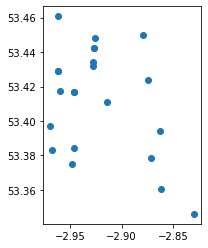

In [37]:
Affordable_food_outlets.plot()

In [38]:
# Write out the food initatives location as a geojson for use in the mapbox map
Affordable_food_outlets.to_file("Data/Out/Affordable_food_iniatives.geojson", driver='GeoJSON')

# Emergency food initatives

In [39]:
Emergency_food_sheet = pd.ExcelFile('Data/emergency_food_providers.xlsx')

In [40]:
Emergency_food_sheet.sheet_names

['Sheet1', 'Sheet2']

In [41]:
Food_parcel=pd.read_excel(Emergency_food_sheet, 'Sheet1')
Food_parcel=Food_parcel.dropna(how='all')
Food_parcel=Food_parcel.rename(columns=lambda x: x.strip())
Food_parcel=Food_parcel.rename(columns={'Emergency food parcel provider':'Name'})

Meal_providers=pd.read_excel(Emergency_food_sheet, 'Sheet2')
Meal_providers=Meal_providers.dropna(how='all')
Meal_providers=Meal_providers.rename(columns=lambda x: x.strip())
Meal_providers=Meal_providers.rename(columns={'Emergency meal provider':'Name'})


Food_parcel['Category']='Food_parcels'
Meal_providers['Category']='Meal_providers'


Emergency_food_suppliers = pd.concat([Food_parcel,Meal_providers] , ignore_index=True)



In [42]:
Emergency_food_suppliers 


,Name,Address,Postcode,Category
0,Deysbrook Village Centre,"Deysbrook Way, Liverpool",L12 4XF,Food_parcels
1,Alive Believers Centre,"259-261 Boaler Street, Liverpool",L6 9DH,Food_parcels
2,All Saints Liverpool,"55 Sheil Road, Liverpool",L6 3AD,Food_parcels
3,St. James in the City,"St. James in the City, Upper Parliament Street...",L8 1UR,Food_parcels
4,Torus Foundation,"FireFit Hub, 115 Upper Warwick Street",L8 8HD,Food_parcels
...,...,...,...,...
57,Liverpool Lighthouse,"Oakfield Road, Anfield, Liverpool",L4 0UF,Meal_providers
58,Kensington Methodist Church,"Kensington Methodist Church, 294 Kensington, ...",L7 2RN,Meal_providers
59,The Florence Institute Trust (The Florrie),"377 Mill Street, Liverpool",L8 4RF,Meal_providers
60,The New Belve Youth and Community Centre,"89-91 Miles Street, Liverpool",L8 4PX,Meal_providers


In [43]:
Emergency_food_suppliers['Addresses']=Emergency_food_suppliers['Address']+" "+Emergency_food_suppliers["Postcode"]+" "+" UK"

In [44]:
# Drop the mobile food suppliers
Emergency_food_suppliers=Emergency_food_suppliers[Emergency_food_suppliers['Address']!="Mobile "]

start_time = time()
Emergency_food_suppliers["lat"] , Emergency_food_suppliers["lon"] = zip(*Emergency_food_suppliers["Addresses"].apply(long_lat_func))

time_elapsed= round((time() - start_time)/60,2)
print("--- %s minutes ---" % (time_elapsed))

--- 0.5 minutes ---


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [45]:
# Subsets to drop the na terms
Emergency_food_suppliers=Emergency_food_suppliers.dropna(subset=['lon', 'lat'])
Emergency_food_suppliers=Emergency_food_suppliers.dropna(subset=['lon', 'lat'])
Emergency_food_suppliers=Emergency_food_suppliers.dropna(subset=['Name'])
Emergency_food_suppliers=Emergency_food_suppliers.dropna(subset=['Address'])

#Converts the longitude and latitude as points data to give the geocoordinates for the data frame
geometry = [Point(xy) for xy in zip(Emergency_food_suppliers['lon'], Emergency_food_suppliers['lat'])]



# Create a GeoDataFrame from the data
Emergency_food_suppliers= gpd.GeoDataFrame(Emergency_food_suppliers, crs = 'epsg:4326' , geometry = geometry)

<AxesSubplot:>

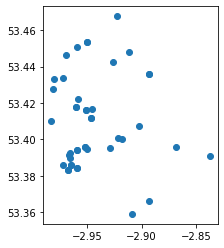

In [46]:
Emergency_food_suppliers.plot()

In [47]:
Emergency_food_suppliers.to_file("Data/Out/Emergency_food_suppliers.geojson", driver='GeoJSON')

# Extract the ward area boundaries from the API

In [48]:
URL = "http://statistics.data.gov.uk/resource.json?uri=http%3A%2F%2Fstatistics.data.gov.uk%2Fid%2Fstatistical-geography%2F{code}%2Fgeometry"

# Function to call the API with the geography codes and return the shape files using the API
def get_shape(gss_code):
    return requests.get(URL.format(code=gss_code)).json()

In [49]:
# Import the ward codes

In [50]:
food_poverty_stats=pd.read_csv("Data/Food_Poverty_Health_stats.csv")
food_poverty_stats.tail(n=5)

,WardCode,WardName,Year,Ward_DASR_Cancers_Under75,Liverpool_cancers_Under75,Ward_DASR_cvd_Under754,Liverpool_cvd_Under755,Ward_Reception_Overweight_Obese,Liverpool_Reception_Overweight_Obese,England_Reception_Overweight_Obese,Ward_Year6_Overweight_obese,Liverpool_Year6_Overweight_Obese,England_Year6_Overweight_Obese,Ward_alcohol_specific_admissions,Liverpool_alcohol_specific_admissions,England_alcohol_specific_admissions
150,E05000912,Wavertree,2020,185.505168,161.91919,89.562031,102.098598,26.0,26.8,23.0,27.9,41.5,35.2,700.5,1359.7,644.1
151,E05000913,West Derby,2020,104.307489,161.91919,68.388098,102.098598,20.6,26.8,23.0,35.1,41.5,35.2,793.7,1359.7,644.1
152,E05000914,Woolton,2020,67.342402,161.91919,44.288680,102.098598,22.2,26.8,23.0,26.4,41.5,35.2,597.7,1359.7,644.1
153,E05000915,Yew Tree,2020,142.877012,161.91919,67.773772,102.098598,31.0,26.8,23.0,35.8,41.5,35.2,1294.7,1359.7,644.1
154,E08000012,Liverpool,2020,161.919190,161.91919,102.098598,102.098598,26.8,26.8,23.0,41.5,41.5,35.2,1176.6,1359.7,644.1


In [51]:
# Subsets so we look just at 2020 data and drop the general all Liverpool data
food_poverty_stats2020=food_poverty_stats[(food_poverty_stats['Year']==2020) & (food_poverty_stats['WardName']!="Liverpool")]
food_poverty_stats2020.head(n=5)

,WardCode,WardName,Year,Ward_DASR_Cancers_Under75,Liverpool_cancers_Under75,Ward_DASR_cvd_Under754,Liverpool_cvd_Under755,Ward_Reception_Overweight_Obese,Liverpool_Reception_Overweight_Obese,England_Reception_Overweight_Obese,Ward_Year6_Overweight_obese,Liverpool_Year6_Overweight_Obese,England_Year6_Overweight_Obese,Ward_alcohol_specific_admissions,Liverpool_alcohol_specific_admissions,England_alcohol_specific_admissions
124,E05000886,Allerton and Hunts Cross,2020,161.265534,161.91919,87.231658,102.098598,21.6,26.8,23.0,36.9,41.5,35.2,700.9,1359.7,644.1
125,E05000887,Anfield,2020,197.133607,161.91919,173.637910,102.098598,31.2,26.8,23.0,39.4,41.5,35.2,1694.9,1359.7,644.1
126,E05000888,Belle Vale,2020,179.584437,161.91919,103.040845,102.098598,28.8,26.8,23.0,45.3,41.5,35.2,1063.1,1359.7,644.1
127,E05000889,Central,2020,100.539600,161.91919,129.607434,102.098598,25.0,26.8,23.0,48.9,41.5,35.2,983.6,1359.7,644.1
128,E05000890,Childwall,2020,111.995170,161.91919,65.638654,102.098598,26.5,26.8,23.0,30.7,41.5,35.2,470.4,1359.7,644.1


In [52]:
#Create a list of features to stick the different wards together into a single geojson
features = []


for ward in food_poverty_stats2020['WardCode']:
       boundary=get_shape(ward)
       # Extract the polygon coordinates from geojson
       polygon_boundary=boundary[0]["http://www.opengis.net/ont/geosparql#asWKT"][0]['@value']
       # Use shapely to load into the geometry
       features.append(Feature(geometry=shapely.wkt.loads(polygon_boundary),properties={"WardCode": ward }))
        
        
Liverpool_wards = FeatureCollection(features)


# Write it out as a geojson
with open('Data/Liverpool_wards.geojson', 'w') as f:
   dump(Liverpool_wards, f)

# Read in the geojson
filename = "Data/Liverpool_wards.geojson"
file = open(filename, encoding='latin1')
Liverpool_wards = gpd.read_file(file)




In [53]:
# Merge with the other ward data, seems simpler to do it this way, but maybe not
Liverpool_wards=Liverpool_wards.merge(food_poverty_stats2020, how='inner', on='WardCode')

In [54]:
list(Liverpool_wards)

['WardCode',
 'geometry',
 'WardName',
 'Year',
 'Ward_DASR_Cancers_Under75',
 'Liverpool_cancers_Under75',
 'Ward_DASR_cvd_Under754',
 'Liverpool_cvd_Under755',
 'Ward_Reception_Overweight_Obese',
 'Liverpool_Reception_Overweight_Obese',
 'England_Reception_Overweight_Obese',
 'Ward_Year6_Overweight_obese',
 'Liverpool_Year6_Overweight_Obese',
 'England_Year6_Overweight_Obese',
 'Ward_alcohol_specific_admissions',
 'Liverpool_alcohol_specific_admissions',
 'England_alcohol_specific_admissions']

In [55]:
measures=["Ward_DASR_Cancers_Under75","Ward_DASR_cvd_Under754" ,
          "Ward_Reception_Overweight_Obese", 
         "Ward_Year6_Overweight_obese" , 
          "Ward_alcohol_specific_admissions"]


In [56]:
wards_ranked=pd.DataFrame(food_poverty_stats2020["WardCode"])


# converts the variables into quintiles and then adds to the original Geodataframe (adding as a straight dataframe causes problems)
for measure in measures: 
    new_col=pd.DataFrame(np.ceil(food_poverty_stats2020[measure].rank(pct=True).mul(5)).astype('Int64')).rename(columns={measure: measure+"_rank"})
    wards_ranked=pd.concat([wards_ranked, new_col], axis=1)



In [57]:
# Merge with the other ward data, seems simpler to do it this way, but maybe not
Liverpool_wards=Liverpool_wards.merge(wards_ranked, on='WardCode')

In [58]:
Liverpool_wards

,WardCode,geometry,WardName,Year,Ward_DASR_Cancers_Under75,Liverpool_cancers_Under75,Ward_DASR_cvd_Under754,Liverpool_cvd_Under755,Ward_Reception_Overweight_Obese,Liverpool_Reception_Overweight_Obese,...,Liverpool_Year6_Overweight_Obese,England_Year6_Overweight_Obese,Ward_alcohol_specific_admissions,Liverpool_alcohol_specific_admissions,England_alcohol_specific_admissions,Ward_DASR_Cancers_Under75_rank,Ward_DASR_cvd_Under754_rank,Ward_Reception_Overweight_Obese_rank,Ward_Year6_Overweight_obese_rank,Ward_alcohol_specific_admissions_rank
0,E05000886,"POLYGON ((-2.85619 53.37873, -2.85399 53.37701...",Allerton and Hunts Cross,2020,161.265534,161.91919,87.231658,102.098598,21.6,26.8,...,41.5,35.2,700.9,1359.7,644.1,3,2,2,2,2
1,E05000887,"POLYGON ((-2.95078 53.43969, -2.94680 53.43824...",Anfield,2020,197.133607,161.91919,173.637910,102.098598,31.2,26.8,...,41.5,35.2,1694.9,1359.7,644.1,4,5,4,3,4
2,E05000888,"POLYGON ((-2.83735 53.39985, -2.83667 53.39825...",Belle Vale,2020,179.584437,161.91919,103.040845,102.098598,28.8,26.8,...,41.5,35.2,1063.1,1359.7,644.1,4,3,4,4,2
3,E05000889,"POLYGON ((-2.96224 53.41424, -2.96285 53.41376...",Central,2020,100.539600,161.91919,129.607434,102.098598,25.0,26.8,...,41.5,35.2,983.6,1359.7,644.1,1,4,3,5,2
4,E05000890,"POLYGON ((-2.90149 53.40700, -2.89643 53.40605...",Childwall,2020,111.995170,161.91919,65.638654,102.098598,26.5,26.8,...,41.5,35.2,470.4,1359.7,644.1,2,1,3,1,1
5,E05000891,"POLYGON ((-2.90290 53.39152, -2.89920 53.39042...",Church,2020,46.738555,161.91919,48.824103,102.098598,23.0,26.8,...,41.5,35.2,321.6,1359.7,644.1,1,1,2,1,1
6,E05000892,"POLYGON ((-2.91789 53.43626, -2.92224 53.43374...",Clubmoor,2020,231.766277,161.91919,94.295583,102.098598,17.6,26.8,...,41.5,35.2,1274.1,1359.7,644.1,5,3,1,4,3
7,E05000893,"POLYGON ((-2.94267 53.44824, -2.95045 53.44581...",County,2020,158.285007,161.91919,149.249760,102.098598,28.8,26.8,...,41.5,35.2,1745.8,1359.7,644.1,3,5,4,4,5
8,E05000894,"POLYGON ((-2.89028 53.35901, -2.89278 53.35713...",Cressington,2020,109.960751,161.91919,87.360836,102.098598,17.9,26.8,...,41.5,35.2,636.1,1359.7,644.1,2,3,1,2,1
9,E05000895,"POLYGON ((-2.89144 53.46310, -2.89117 53.46268...",Croxteth,2020,93.531778,161.91919,87.208128,102.098598,23.5,26.8,...,41.5,35.2,870.6,1359.7,644.1,1,2,2,5,2


In [59]:
Liverpool_wards.to_file("Data/Out/Liverpool_wards.geojson", driver='GeoJSON')

# Extracting the Liverpool border area file

In [60]:
features=[]

Liv=food_poverty_stats[(food_poverty_stats['WardName']=="Liverpool") & (food_poverty_stats['Year']==2020) ]
# Get the shape file for the Liverpool city code
boundary=get_shape("E08000012")

In [61]:
polygon_boundary=boundary[0]["http://www.opengis.net/ont/geosparql#asWKT"][0]['@value']
# Use shapely to load into the geometry
features.append(Feature(geometry=shapely.wkt.loads(polygon_boundary),properties={"WardCode": "E08000012" }))

In [62]:
Liverpool_boundary = FeatureCollection(features)

In [63]:
# Write it out as a geojson, note this may require reformatting to reload into mapbox
with open('Data/Out/Liverpool_boundary.geojson', 'w') as f:
    dump( Liverpool_boundary, f)

# Adding in the foodbank information

In [64]:
foodbanks=pd.read_csv("Data/Liverpool_foodbanks_geocode_input.csv")

In [65]:
foodbanks.head(n=3)

,Category,Company Name,Region,name,Street Address,City,State,Zip,Mobile Number,Website Address,Email,Reviews Average,Count Of Review
0,Charity,The Trussell Trust Food Bank,Liverpool,60 Peel Rd Bootle L20 4RW,60 Peel RdBootle L20 4RW,60 Peel Rd,BootleL20,4.0,0151 933 1300,trusselltrust.org,reg_with_fund_reg@2x.png,5.0,5.0
1,Foodbank,Christ Church Community Centre,Liverpool,8 Oxford Rd Bootle L20 9HW,8 Oxford RdBootle L20 9HW,8 Oxford Rd,BootleL20,9.0,NaN,NaN,NaN,NaN,NaN
2,Church,St Oswalds Church Centre,Liverpool,Ronald Ross Ave Netherton Bootle L30 5RD,Ronald Ross AveNetherton,Liverpool,BootleL30,5.0,0151 521 6002,NaN,NaN,3.0,3.0


In [66]:
# Adjust the coding of the address to make the geocoding more accurate

def complete_address(x):
  if "Bootle" in x:
    return x+", Bootle, UK"
  if "Waterloo" in x:
    return x+", Waterloo, UK"
  if "Speke" in x:
    return x+", Speke, UK"
  else:
    return x+", Liverpool, UK"


foodbanks["full_address"]=foodbanks["name"].apply(complete_address)

In [67]:
# Applies the geocoding function

start_time = time()

foodbanks["lat"] , foodbanks["lon"] = zip(*foodbanks["full_address"].apply(long_lat_func))


time_elapsed= round((time() - start_time)/60,2)
print("--- %s minutes ---" % (time_elapsed))

--- 0.35 minutes ---


In [68]:
# Subsets to drop the na terms
foodbanks=foodbanks.dropna(subset=['lon', 'lat'])

# Foodbanks remove Bootle
foodbanks=foodbanks[~foodbanks["full_address"].str.contains('Bootle')]

#Converts the longitude and latitude as points data to give the geocoordinates for the data frame
geometry = [Point(xy) for xy in zip(foodbanks['lon'], foodbanks['lat'])]


# Create a GeoDataFrame 
foodbanks_geo = gpd.GeoDataFrame(foodbanks, crs = 'epsg:4326' , geometry = geometry)

from shapely.ops import cascaded_union
#Liverpool_boundary = Liverpool_wards.dissolve(by='continent', aggfunc='sum')


In [69]:
# Selects the points that fall within Liverpool

PointInPoly = gpd.sjoin(foodbanks_geo,Liverpool_lsoa, how='left',op='within') 

In [70]:
# Create a GeoDataFrame from art and verify the type
foodbanks_geo = gpd.GeoDataFrame(PointInPoly, crs = 'epsg:4326' , geometry = geometry)


#map.add_data(data=foodbanks_geo, name="food_banks")




<AxesSubplot:>

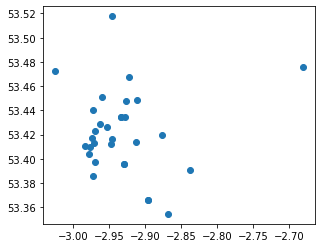

In [71]:
foodbanks_geo.plot()

In [72]:
foodbanks_geo.to_file("Data/Out/Foodbanks.geojson", driver='GeoJSON')


# Get a bounding box

This expands the bounding box around Liverpool so that the map border is wider than the area of the Liverpool shape file

In [73]:
Liverpool_wards_expand=Liverpool_wards

In [74]:
Liverpool_wards_expand.total_bounds

array([-3.008753, 53.326789, -2.818   , 53.474967])

In [75]:
Liverpool_wards_expand.geometry.iloc[0] = shapely.affinity.scale(Liverpool_wards_expand.geometry.iloc[0], xfact=1.05, yfact=1.05, origin='center')

In [76]:
Liverpool_wards_expand.total_bounds

array([-3.008753, 53.326789, -2.818   , 53.474967])

In [77]:
# Check that everything has been written out
! ls Data


 Affordable_food_inititives_Liverpool.xlsx
 Food_Poverty_Health_stats.csv
 Food_outlets_geo.geojson
 Foodbanks.geojson
 Liverpool_food_outlets.xml
 Liverpool_foodbanks_geocode_input.csv
 Liverpool_lsoa.geojson
 Liverpool_wards.geojson
 Out
 efdi_england.csv
 emergency_food_providers.xlsx
 map_data_processing
'~$Affordable_food_inititives_Liverpool.xlsx'
'~$emergency_food_providers.xlsx'


In [78]:
pwd

'/notebooks'

In [79]:
ls

Data/  Further_analysis.ipynb  Liverpool_map.ipynb  Liverpool_map.py
